In [9]:
from ff_energy.ffe.slurm import SlurmJobHandler
from pathlib import Path
import pandas as pd
import jax.numpy as jnp
import itertools as it
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



from ff_energy.ffe.potential import (
    LJ,
    DE,
)

from ff_energy.ffe.ff import FF

from ff_energy.plotting.ffe_plots import plot_energy_MSE, plot_ff_fit
from ff_energy.plotting.plotting import set_style
from ff_energy.plotting.fit_results import residuals_plot
from ff_energy.logs.logging import hide_logs

hide_logs()


import scienceplots
set_style(no_latex=True)

# sns.set_style()
# plt.style.use(["science", "no-latex"])


from ff_energy.ffe.ff_fit import (
    load_ff,
    fit_func,
    fit_repeat,
)

from ff_energy.utils.ffe_utils import pickle_output, read_from_pickle, str2int, PKL_PATH
from ff_energy.utils.json_utils import load_json

structure_data = {
    "dcm": "",
    "water_cluster": PKL_PATH / "20230823_water_clusters.pkl.pkl",
}

"""
Variables
"""
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100, 2000)
CHGPEN_bound = [(chg_bound), (chg_bound), (chg_bound), (chg_bound), (0, 2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), (1, 8), (6, 20))

NFIT_COUL = 1
NFIT_LJ = 4
NFIT_DE = 6

pkl_files = []
json_object = load_json("exp1.json")
#  make a product of all the values in the json object
experiments = list(it.product(*json_object.values()))
print(f"N experiments: {len(experiments)}")

N experiments: 5


In [4]:
experiments

[('pbe0dz', 'dcm', 'ELECnull', 'lj'),
 ('pbe0dz', 'dcm', 'ELECci', 'lj'),
 ('pbe0dz', 'dcm', 'ELECpol', 'lj'),
 ('pbe0dz', 'dcm', 'ELECm', 'lj'),
 ('pbe0dz', 'dcm', 'ELECp', 'lj')]

In [5]:
fitted_ = {_.stem: pd.read_pickle(_) for _ in list(PKL_PATH.glob("*fitted*"))}
fitted_.keys()

2023-09-06 11:14:53 | DEBUG | xla_bridge:_init_backend:482 - Initializing backend 'interpreter'
2023-09-06 11:14:53 | DEBUG | xla_bridge:_init_backend:494 - Backend 'interpreter' initialized
2023-09-06 11:14:53 | DEBUG | xla_bridge:_init_backend:482 - Initializing backend 'cpu'
2023-09-06 11:14:53 | DEBUG | xla_bridge:_init_backend:494 - Backend 'cpu' initialized
2023-09-06 11:14:53 | DEBUG | xla_bridge:_init_backend:482 - Initializing backend 'cuda'
2023-09-06 11:14:53 | INFO | xla_bridge:backends:450 - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-06 11:14:53 | DEBUG | xla_bridge:_init_backend:482 - Initializing backend 'rocm'
2023-09-06 11:14:53 | INFO | xla_bridge:backends:450 - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-09-06 11:14:53 | DEBUG | xla_bridge:_init_backend:482 - Initializing backend 'tpu'
2023-09-06 11:14:53 | INFO | xla_bridge:backends

dict_keys(['ELECpol_dcm_lj_fitted', 'ELECnull_water_cluster_lj_fitted', 'ELECci_dcm_lj_fitted', 'ELECp_dcm_lj_fitted', 'ELECnull_dcm_lj_fitted', 'ELECk_water_cluster_lj_fitted', 'ELECm_dcm_lj_fitted', 'ELECci_water_cluster_lj_fitted', 'ELECp_water_cluster_lj_fitted', 'ELECpol_water_cluster_lj_fitted', 'ELECm_water_cluster_lj_fitted'])

In [6]:
fitkeys = list(fitted_.keys())
fitkeys = [
  #   'ELECnull_water_cluster_lj_fitted',
  # 'ELECci_water_cluster_lj_fitted',
  'ELECpol_water_cluster_lj_fitted',
  # 'ELECk_water_cluster_lj_fitted',
  # 'ELECm_water_cluster_lj_fitted',
  # 'ELECp_water_cluster_lj_fitted',
  # 'ELECnull_dcm_lj_fitted',
  # 'ELECci_dcm_lj_fitted',
  # 'ELECpol_dcm_lj_fitted',
  # 'ELECm_dcm_lj_fitted',
  # 'ELECp_dcm_lj_fitted'
]

In [10]:
def eval_(model, x, num_segments=201):
    model.num_segments = num_segments
    return np.asarray(model.eval_jax(x))

for I, _ in enumerate(fitkeys):
    key = fitkeys[I]
    m = fitted_[key]
    nseg = 201 if "dcm" in key else 500
    results = [_.fun for _ in m.opt_results]
    # data_vals = [eval_(m, _.x, nseg) for _ in m.opt_results]
    parm_vals = [_.x for _ in fitted_[key].opt_results]
    dataframe = pd.DataFrame(fitted_[key].opt_results)
    # dataframe["values"] = data_vals

    elec = fitted_[key].df[fitted_[key].elec] 
    targets = fitted_[key].targets 
    best = dataframe["fun"].sort_values().index[0]
        
    best_parm = parm_vals[best]
    vals = eval_(m, best_parm, nseg)
    RMSE = dataframe.fun.min() **0.5
    labelkey = f"{key.replace('_', ' ').strip('ELEC').split()[0].upper()}: {RMSE :.1f} kcal/mol"
        
    resid = targets - vals
    df_test = pd.DataFrame({"target": targets+elec, "residuals": resid, "vals": vals+elec})
    var_res = f"var_res: {np.nanmean(resid)}"
    # print(df_test.dropna(), RMSE)
    df_test = df_test.dropna()
    residuals_plot(df_test, "test")
    
    
    



DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:58 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:58 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:59 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:59 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of Axes not in the figure, so title not moved
2023-09-06 11:15:59 | DEBUG | _base:_update_title_position:3003 - top of Axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:to

In [9]:
# fitted_[key].eval_jax(best_parm).shape
fitted_[key].num_segments = 201
fitted_[key].eval_jax(best_parm)

2023-09-05 20:45:24 | DEBUG | dispatch:log_elapsed_time:272 - Finished tracing + transforming LJRUN for pjit in 0.0022249221801757812 sec
2023-09-05 20:45:24 | DEBUG | pxla:lower_sharding_computation:2440 - Compiling LJRUN for with global shapes and types [ShapedArray(float32[343710]), ShapedArray(int32[343710]), ShapedArray(int32[343710]), ShapedArray(float32[6])]. Argument mapping: (GSPMDSharding({replicated}), GSPMDSharding({replicated}), GSPMDSharding({replicated}), GSPMDSharding({replicated})).
2023-09-05 20:45:24 | DEBUG | xla_bridge:get_compile_options:125 - get_compile_options: num_replicas=1 num_partitions=1 device_assignment=[[CpuDevice(id=0)]]
2023-09-05 20:45:24 | DEBUG | dispatch:log_elapsed_time:272 - Finished XLA compilation of jit(LJRUN) in 0.04702496528625488 sec


Array([ -8.679099 , -17.416534 ,  -8.797241 ,  -9.175651 , -13.7771   ,
        -8.499314 ,  -9.963039 ,  -9.14117  , -14.0059595, -12.961435 ,
       -12.382614 , -15.193031 ,  -6.543729 , -15.574745 ,  -9.399832 ,
       -12.44007  ,  -9.360146 , -10.580072 , -12.131478 , -13.9265175,
       -11.387453 , -15.925692 , -20.143423 , -14.617401 , -11.566539 ,
       -13.694064 , -11.415711 , -15.369389 , -14.560101 , -14.895153 ,
        -8.68453  , -15.447062 , -13.693357 , -13.076864 ,  -9.691469 ,
        -6.9299655, -14.998952 ,  -8.011708 , -10.821518 , -12.165156 ,
        -9.769529 ,  -6.5140953, -15.216439 ,  -8.7444725, -12.945551 ,
       -14.0941925, -14.715478 , -10.861329 , -16.436146 , -15.986576 ,
       -10.908183 , -11.687253 , -16.665436 , -11.939227 , -12.580796 ,
       -12.593601 , -14.474608 , -17.117025 , -11.703036 ,  -9.8325405,
        -9.813097 , -13.39751  , -14.683071 , -16.341877 , -11.169738 ,
       -11.317979 , -13.676018 , -11.918437 , -14.158367 , -11.5

In [262]:
# distax = pw.Brick(figsize=FIGSIZE)
# _ = sns.kdeplot(data=df_test, x="target", color="blue", ax=distax, label="target")
# _ = sns.kdeplot(data=df_test, x="vals", color="red", ax=distax, label="fit")
# # distax.plot([0,0], [-100,0], c="purple")

In [273]:
# _.__dict__

In [21]:
df_test

,target,residuals,vals
100_1018_DCM_120_967,-7.830045,0.849054,-8.679099
100_1019_DCM_120_565,-15.434519,1.982016,-17.416534
100_1024_DCM_121_932,-7.708785,1.088456,-8.797241
100_1053_DCM_123_948,-11.485918,-2.310267,-9.175651
100_1100_DCM_129_15,-11.920833,1.856267,-13.777100
...,...,...,...
100_979_DCM_115_117,-16.107422,-5.818358,-10.289063
100_983_DCM_116_25,-14.879883,-0.614049,-14.265834
100_986_DCM_116_989,-14.292064,1.234733,-15.526796
100_98_DCM_12_534,-14.645715,-1.673348,-12.972366


In [26]:
sns.jointplot(data=df_test, x="target", y="vals", kind="reg", marker="o")

RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../7f1cac901561858373fb5fafcf028f3a.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.

kpathsea: Running mktexfmt latex.fmt
Can't locate mktexlsr.pl in @INC (@INC contains: /cluster/home/boittier/miniforge3/envs/pycharmm/share/tlpkg /cluster/home/boittier/miniforge3/envs/pycharmm/share/texmf-dist/scripts/texlive /usr/local/lib64/perl5/5.32 /usr/local/share/perl5/5.32 /usr/lib64/perl5/vendor_perl /usr/share/perl5/vendor_perl /usr/lib64/perl5 /usr/share/perl5) at /cluster/home/boittier/miniforge3/envs/pycharmm/bin/mktexfmt line 23.
BEGIN failed--compilation aborted at /cluster/home/boittier/miniforge3/envs/pycharmm/bin/mktexfmt line 25.
I can't find the format file `latex.fmt'!




In [121]:
# dataframe

In [78]:
# data_vals[0]

array([[<AxesSubplot: title={'center': 'fun'}>]], dtype=object)

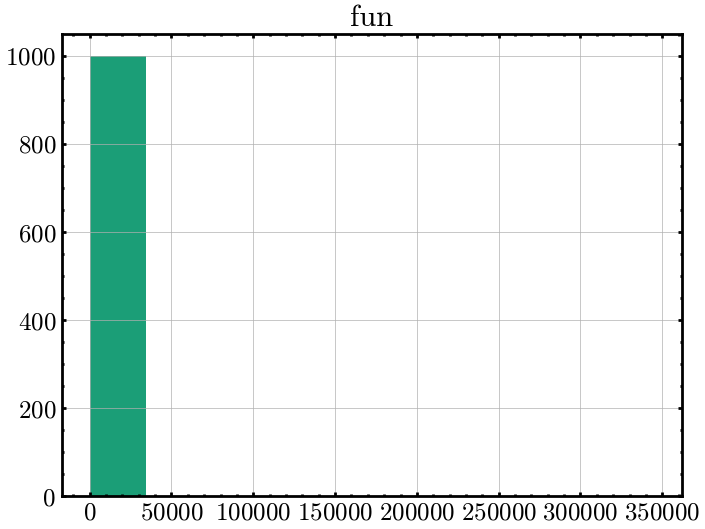

In [61]:
dataframe.hist("fun")

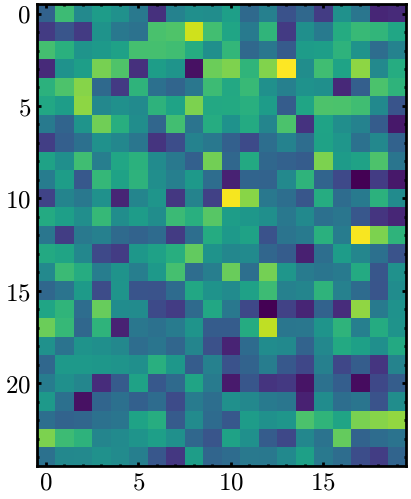

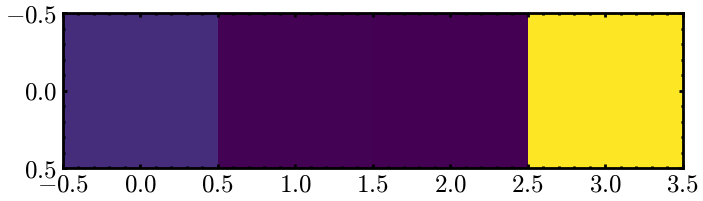

In [21]:
plt.imshow(dataframe["values"][0].reshape(25, 20))
plt.show()
plt.imshow([parm_vals[0]])
plt.show()

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animation():
    n = len(dataframe)

    # Create a set of arrays
    data = [dataframe["values"][i].reshape(25, 20) for i in range(n)]

    # Set up the figure, axis, and initial imshow object
    fig, axs = plt.subplots(2,1)
    im1 = axs[0].imshow(data[0], animated=True)
    im2 = axs[1].imshow([parm_vals[0]], animated=True)

    # Define the update function
    def update(frame):
        im1.set_array(data[frame])
        im2.set_array([parm_vals[frame]])
        _data = (dataframe.iloc[frame])

        text_ = f"fun: {_data['fun']**0.5:.1f}, nfev: {_data['nfev']}"
        axs[0].set_title(text_)
        return [im]

    # Create the animation object
    ani = FuncAnimation(fig, update, frames=len(data), blit=True)

    # Convert the animation to HTML and save it
    html_content = HTML(ani.to_jshtml()).data
    with open("animation.html", "w") as f:
        f.write(html_content)

    print("Animation saved as animation.html")


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>
2023-09-04 10:10:01 | INFO | animation:save:1043 - Animation.save using <class 'matplotlib.animation.HTMLWriter'>
INFO:matplotlib.animation:Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
2023-09-04 10:10:01 | INFO | animation:save:1058 - Disabling savefig.bbox = 'tight', as it may cause frame size to vary, which is inappropriate for animation.
DEBUG:matplotlib.animation:frame size in pixels is 800 x 600
2023-09-04 10:10:01 | DEBUG | animation:_adjust_frame_size:309 - frame size in pixels is 800 x 600
2023-09-04 10:11:21 | WARNING | animation:grab_frame:768 - Animation size has reached 20990940 bytes, exceeding the limit of 20971520.0. If you're sure you want a larger animation embedded, set the animation.embed_limit rc parameter to a larger value (in MB). This and further frames will be dropped.
DEBUG:matplotlib.animation:MovieWriter: cle

Animation saved as animation.html


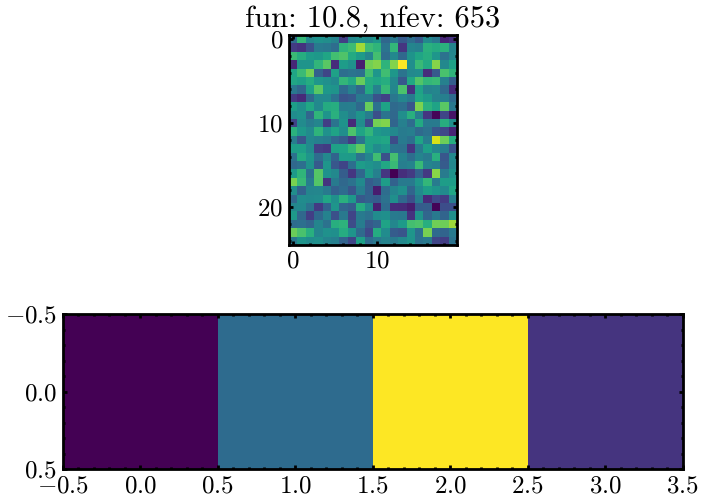

In [58]:
animation()